In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.coordinates import Angle, SkyCoord
from astropy.wcs import WCS
import astropy.units as u

import healpy
import time
from tqdm import tqdm

from billiard.pool import Pool
import multiprocessing
from functools import partial
from multiprocessing import SimpleQueue

from itertools import compress

from mocpy import MOC
from mocpy import WCS as mocWCS

%matplotlib widget

In [2]:
tess1 = '/Users/zgl12/Python_Scripts/SynDiff/TESS_S20/tess2019359025923-s0020-1-1-0165-s_ffic.fits'

tess_filename = 'tess2019359002923-s0020-1-1-0165-s_ffic.fits'
# folder = '/Users/zgl12/Modules/SynDiff/development/PS1_to_TESS/data/'

with fits.open(tess1) as hdul:
    hdr = hdul[1].header
    wcs = WCS(hdr)
    data = hdul[1].data

fprint = wcs.calc_footprint()

min_tess_ra = np.min(fprint[:,0])
max_tess_ra = np.max(fprint[:,0])

min_tess_dec = np.min(fprint[:,1])
max_tess_dec = np.max(fprint[:,1])

print(wcs.all_pix2world(1100, 1600, 0))

[array(118.84519408), array(42.02109849)]


Set MJD-END to 58842.150305 from DATE-END'. [astropy.wcs.wcs]


In [3]:
skycells = pd.read_csv('/Users/zgl12/Modules/SynDiff/development/skycell_coordinates.csv')

skycells
# fprint

,Name,RA,DEC,RA_Corner1,DEC_Corner1,RA_Corner2,DEC_Corner2,RA_Corner3,DEC_Corner3,RA_Corner4,DEC_Corner4
0,skycell.0635.000,2.128449,-31.790821,2.389603,-32.003520,2.378963,-31.569044,1.868454,-31.577489,1.876814,-32.012105
1,skycell.0635.001,1.655734,-31.797815,1.915981,-32.011522,1.907447,-31.576915,1.396661,-31.583488,1.402912,-32.018204
2,skycell.0635.002,1.182794,-31.803062,1.442098,-32.017766,1.435673,-31.583058,0.924678,-31.587754,0.928818,-32.022541
3,skycell.0635.003,0.709692,-31.806562,0.968018,-32.022250,0.963703,-31.587467,0.452570,-31.590286,0.454596,-32.025115
4,skycell.0635.004,0.236493,-31.808312,0.493804,-32.024969,0.491603,-31.590143,359.980401,-31.591082,359.980313,-32.025925
...,...,...,...,...,...,...,...,...,...,...,...
200895,skycell.2643.095,6.343224,88.189445,359.400704,88.416914,359.529451,87.984098,11.674656,87.941618,14.744119,88.363129
200896,skycell.2643.096,18.437270,88.103228,13.612718,88.371271,10.765393,87.948082,22.046761,87.825282,27.284176,88.218955
200897,skycell.2643.097,29.056199,87.941649,26.325328,88.233942,21.230223,87.837530,31.103547,87.646053,37.539010,88.003929
200898,skycell.2643.098,37.875978,87.720733,36.774491,88.023996,30.405626,87.663035,38.718108,87.417052,45.596168,87.738238


In [4]:
# t_y, t_x = np.shape(data)
# ty, tx = np.mgrid[:t_y, :t_x]

# print(ty)

# ty_input = ty.ravel()
# tx_input = tx.ravel()

# print(np.shape(data))
# print(len(tx_input))
# tpix_coord_input = np.asarray([ty_input, tx_input]).T

# ravelled_indices = np.arange(len(tx_input))

_ra, _dec = skycells.RA.values, skycells.DEC.values


In [5]:
start = time.time()

pixel_vertices = []
# 
# _ra, _dec = wcs.all_pix2world(tpix_coord_input[:,1], tpix_coord_input[:,0], 0)
mask = (_ra >= (min_tess_ra - 0.5)) & (_ra < (max_tess_ra + 0.5)) & (_dec >= (min_tess_dec - 0.5)) & (_dec < (max_tess_dec + 0.5))

filtered_indices = np.where(mask)[0]

filtered_skycells = skycells.iloc[filtered_indices].reset_index(drop=True)

sc_centers = np.column_stack((_ra[filtered_indices], _dec[filtered_indices]))
sc_center_ra = _ra[filtered_indices]
sc_center_dec = _dec[filtered_indices]
sc_names = filtered_skycells['Name'].values
sc_names = [int(name.split('.')[1] + name.split('.')[2]) for name in sc_names]
# enc_tess_pix_indices = np.asarray(tess_indices)[ps1_mask]

for i in range(len(filtered_skycells)):
    corner1 = wcs.all_world2pix(filtered_skycells.iloc[i]['RA_Corner1'], filtered_skycells.iloc[i]['DEC_Corner1'], 0)
    corner2 = wcs.all_world2pix(filtered_skycells.iloc[i]['RA_Corner2'], filtered_skycells.iloc[i]['DEC_Corner2'], 0)
    corner3 = wcs.all_world2pix(filtered_skycells.iloc[i]['RA_Corner3'], filtered_skycells.iloc[i]['DEC_Corner3'], 0)
    corner4 = wcs.all_world2pix(filtered_skycells.iloc[i]['RA_Corner4'], filtered_skycells.iloc[i]['DEC_Corner4'], 0)

    sc_poly = wcs.all_pix2world([corner1, corner2, corner3, corner4], 0)
    pixel_vertices.append(sc_poly)

print("Number of TESS pixels: %s" % len(pixel_vertices))

print('\nTime taken:', time.time() - start)


Number of TESS pixels: 1513

Time taken: 1.927804946899414


In [6]:
filtered_skycells

# sc_names

,Name,RA,DEC,RA_Corner1,DEC_Corner1,RA_Corner2,DEC_Corner2,RA_Corner3,DEC_Corner3,RA_Corner4,DEC_Corner4
0,skycell.2107.030,112.289836,37.374053,112.557317,37.150697,112.572420,37.586178,112.020672,37.596874,112.008802,37.161224
1,skycell.2107.031,111.781339,37.382771,112.050494,37.160513,112.062610,37.596151,111.510512,37.604476,111.501635,37.168706
2,skycell.2107.032,111.272561,37.389315,111.543351,37.168172,111.552473,37.603933,111.000112,37.609883,110.994233,37.174028
3,skycell.2107.033,110.763582,37.393678,111.035965,37.173672,111.042090,37.609521,110.489553,37.613092,110.486675,37.177186
4,skycell.2107.034,110.254482,37.395861,110.528416,37.177008,110.531541,37.612911,109.978917,37.614101,109.979041,37.178179
...,...,...,...,...,...,...,...,...,...,...,...
1508,skycell.2369.015,130.577390,52.584685,130.936145,52.366481,130.936421,52.803782,130.214997,52.801760,130.222017,52.364492
1509,skycell.2369.016,129.914426,52.580982,130.276464,52.364795,130.270001,52.802068,129.548772,52.796007,129.562526,52.358832
1510,skycell.2369.017,129.251729,52.573579,129.616951,52.359438,129.603753,52.796624,128.882914,52.786527,128.903391,52.349504
1511,skycell.2369.018,128.589474,52.562481,128.957780,52.350413,128.937858,52.787451,128.217603,52.773326,128.244787,52.336515


In [7]:
start = time.time()

t_y, t_x = np.shape(data)
print(np.shape(data))

ty, tx = np.mgrid[:t_y, :t_x]

ty_input = ty.ravel()
tx_input = tx.ravel()

ppix_coord_input = np.asarray([ty_input, tx_input]).T

x2 = ppix_coord_input[:,1]
y2 = ppix_coord_input[:,0]
_ra2, _dec2 = wcs.all_pix2world(x2, y2, 0)

print('\nTime taken:', time.time() - start)

(2078, 2136)

Time taken: 1.9864168167114258


In [8]:
# Get TESS pixels enclosed by the PS1 footprint.

start = time.time()

tess_skycoord = SkyCoord(fprint, unit="deg", frame="icrs")
tess_moc = MOC.from_polygon_skycoord(tess_skycoord, complement=False, max_depth=21)

tess_mask = tess_moc.contains_lonlat(sc_center_ra*u.degree, sc_center_dec*u.degree)
print("Num pix enc: %s" % tess_mask.sum())

print(len(sc_center_ra))

enc_sc_vertices = list(compress(pixel_vertices, tess_mask))#[ps1_mask]
enc_sc_center_ra = np.asarray(sc_center_ra)[tess_mask]
enc_sc_center_dec = np.asarray(sc_center_dec)[tess_mask]
enc_sc_indices = np.asarray(sc_names)[tess_mask]

print(len(enc_sc_vertices))
# enc_tess_pix_indices = np.asarray(tess_indices)[tess_mask]

enc_sc = []
for i in tqdm(range(len(enc_sc_vertices)), desc='Creating MOCs'):
    sc_skycoord = SkyCoord(enc_sc_vertices[i], unit="deg", frame="icrs")
    sc_moc = MOC.from_polygon_skycoord(sc_skycoord, complement=False, max_depth=21)
    enc_sc.append(sc_moc)

# enc_tess_pix = []
# for t in enc_tess_pix_vertices:
#     tess_pix_skycoord = SkyCoord(t, unit="deg", frame="icrs")
#     tess_pix_moc = MOC.from_polygon_skycoord(tess_pix_skycoord, complement=False, max_depth=21)
#     enc_tess_pix.append(tess_pix_moc)

print('\nTime taken:', time.time() - start)

Num pix enc: 899
1513
899


Creating MOCs: 100%|██████████| 899/899 [01:38<00:00,  9.11it/s]


Time taken: 101.99873685836792


In [9]:
# Resolve PS1 pixels into their TESS pixels
start = time.time()

def init_pool(ps1_pixel_ras, ps1_pixel_decs, _tess_pixel_vertices): # shared_queue, 
    global pix_ras, pix_decs, tess_poly
 
    pix_ras = ps1_pixel_ras
    pix_decs = ps1_pixel_decs
    tess_poly = _tess_pixel_vertices
 
    print("\nInitialized pool!")

Nproc=int(multiprocessing.cpu_count()-2) ## I like to reserve 2 CPUs to do other things
print("Num processes: %s" % Nproc)

def initialize_moc_pixel(tess_pix_obj):

    global pix_ras, pix_decs, tess_poly
    
    tess_pix_index, tess_pix_moc, tess_ind = tess_pix_obj
    tp = tess_poly[tess_pix_index]

    _min_ra, _max_ra = np.min(tp[:, 0]) - 0.5, np.max(tp[:, 0]) + 0.5
    _min_dec, _max_dec = np.min(tp[:, 1]) - 0.5, np.max(tp[:, 1]) + 0.5

    search_indices = np.where((pix_ras >= _min_ra) & 
                              (pix_ras <= _max_ra) & 
                              (pix_decs >= _min_dec) & 
                              (pix_decs <= _max_dec))[0]
    
    enc_ps1_pix_mask = tess_pix_moc.contains_lonlat(pix_ras[search_indices]*u.degree, pix_decs[search_indices]*u.degree)
    ps1_ind = np.arange(len(pix_ras))
    ps1_ind = ps1_ind[search_indices][enc_ps1_pix_mask]

    temp_ra = np.asarray(pix_ras[search_indices])[enc_ps1_pix_mask]
    temp_dec = np.asarray(pix_decs[search_indices])[enc_ps1_pix_mask]

    return (tess_ind, temp_ra, temp_dec, ps1_ind)

print(len(enc_sc_indices), len(enc_sc))
sc_payload = [(i,etp,enc_sc_indices[i]) for (i,etp) in enumerate(enc_sc)]

pix_output = []
with Pool(processes=Nproc, initializer=init_pool, initargs=(_ra2, _dec2, enc_sc_vertices)) as pool:
    pix_output = pool.map(initialize_moc_pixel, sc_payload)

print("\n Length of output: %s" % len(pix_output))

print('\nTime taken:', time.time() - start)

Num processes: 6
899 899

Initialized pool!

Initialized pool!

Initialized pool!

Initialized pool!

Initialized pool!

Initialized pool!

 Length of output: 899

Time taken: 46.691102027893066


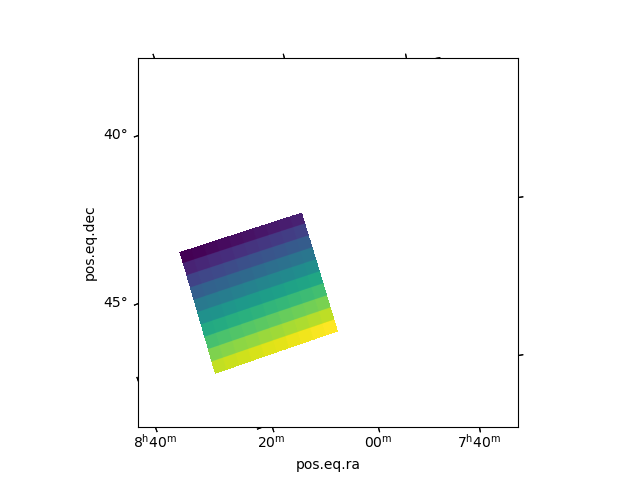

In [19]:
fll = np.full(np.shape(data), np.nan)

for i in range(len(pix_output)):
    if '2247' in str(pix_output[i][0]):
        # continue
        unravel_index = np.unravel_index(pix_output[i][-1], np.shape(data))
        # print(unravel_index)
        fll[unravel_index] = pix_output[i][0]
    # break

plt.figure()
plt.subplot(projection=wcs)
plt.imshow(fll, origin='lower', vmin = np.nanmin(fll), vmax = np.nanmax(fll))
# for i in range(np.shape(data)[1]):
    # plt.axvline(i, color='red', alpha=0.5)
plt.savefig('skycell_tess_pix_proj.png')
plt.show()

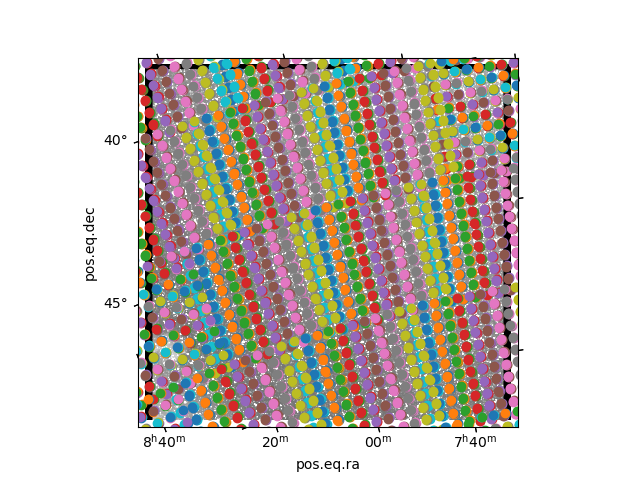

In [11]:
plt.figure()
ax = plt.subplot(projection=wcs)
ax.imshow(data, origin='lower', cmap='gray', vmin = np.nanpercentile(data, 5), vmax = np.nanpercentile(data, 95))
for i in range(len(pixel_vertices)):
    ax.scatter(pixel_vertices[i][:,0], pixel_vertices[i][:,1], transform=ax.get_transform('world'))
    # break


ax.set_xlim(-40, np.shape(data)[1] + 40)
ax.set_ylim(-40, np.shape(data)[0] + 40)

plt.show()

In [12]:
pix_output

[(2108090,
  array([117.65326126, 117.64590483, 117.63854785, ..., 117.09681029,
         117.08947068, 117.08213054]),
  array([39.99614658, 39.9974601 , 39.9987732 , ..., 39.57823551,
         39.57950914, 39.58078235]),
  array([4217635, 4217636, 4217637, ..., 4401387, 4401388, 4401389])),
 (2108091,
  array([117.12838596, 117.12100081, 117.11361514, ..., 116.57384924,
         116.56648288, 116.55911602]),
  array([40.00458788, 40.00586975, 40.00715118, ..., 39.58377366,
         39.58501583, 39.58625756]),
  array([4247607, 4247608, 4247609, ..., 4431359, 4431360, 4431361])),
 (2108092,
  array([116.60381038, 116.59639762, 116.60218043, ..., 116.04488462,
         116.03748558, 116.03008606]),
  array([40.01639775, 40.01764771, 40.01067672, ..., 39.65369064,
         39.6549015 , 39.65611192]),
  array([4275443, 4275444, 4277579, ..., 4437838, 4437839, 4437840])),
 (2108093,
  array([116.07635329, 116.06891512, 116.06147647, ..., 115.52582695,
         115.51839557, 115.51096373])